# Import

In [1]:
from pandas import read_csv, DataFrame, options
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from numpy import array, mean, append, unique, std, log, isnan
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from os import makedirs
from IPython.display import display, Markdown
from statsmodels.formula.api import glm
from math import ceil, floor, sqrt
from pingouin import anova, cronbach_alpha, pairwise_corr, linear_regression, corr
from xgboost import XGBRegressor
from dalex import Explainer
from warnings import filterwarnings
filterwarnings('ignore')
options.display.float_format = '{:.5f}'.format

# Setup
## Load data and setup output dir

In [2]:
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

## Factoring categorical data

In [3]:
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

data["gamer_number"] = data["q9"].map({
    "A frequent video game player": 1,
    "An occasional video game player": 1,
    "A novice video game player": 0,
    "A non-video game player": 0
})

## Composite values

In [4]:
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["comp_average"] = data["comp_mg1"] + data["comp_gmd4"] + data["comp_co5"] + data["comp_co6"]

## NA Inputation
### Means

In [5]:
data["total_breaks"] = data["total_breaks"].fillna(data["total_breaks"].mean())
data["total_submit"] = data["total_submit"].fillna(data["total_submit"].mean())
data["total_snapshot"] = data["total_snapshot"].fillna(data["total_snapshot"].mean())
data["total_view"] = data["total_view"].fillna(data["total_view"].mean())
data["total_manipulate"] = data["total_manipulate"].fillna(data["total_manipulate"].mean())
data["n_puzzle"] = data["n_puzzle"].fillna(data["n_puzzle"].mean())
data["n_complete"] = data["n_complete"].fillna(data["n_complete"].mean())
data["n_tutorial"] = data["n_tutorial"].fillna(data["n_tutorial"].mean())
data["complete_active"] = data["complete_active"].fillna(data["complete_active"].mean())
data["incomplete_active"] = data["incomplete_active"].fillna(data["incomplete_active"].mean())
data["persistence_score"] = data["persistence_score"].fillna(data["persistence_score"].mean())
data["non_per"] = data["non_per"].fillna(data["non_per"].mean())
data["productive"] = data["productive"].fillna(data["productive"].mean())
data["unproductive"] = data["unproductive"].fillna(data["unproductive"].mean())
data["rapid"] = data["rapid"].fillna(data["rapid"].mean())
data["no_beh"] = data["no_beh"].fillna(data["no_beh"].mean())
data["avg_revisit"] = data["avg_revisit"].fillna(data["avg_revisit"].mean())
data["n_attempt"] = data["n_attempt"].fillna(data["n_attempt"].mean())
data["n_failed_att"] = data["n_failed_att"].fillna(data["n_failed_att"].mean())
data["enjoyment"] = data["enjoyment"].fillna(data["enjoyment"].mean())
data["comp_average"] = data["comp_average"].fillna(data["comp_average"].mean())
data["comp_mg1"] = data["comp_mg1"].fillna(data["comp_mg1"].mean())
data["comp_gmd4"] = data["comp_gmd4"].fillna(data["comp_gmd4"].mean())
data["comp_co5"] = data["comp_co5"].fillna(data["comp_co5"].mean())
data["comp_co6"] = data["comp_co6"].fillna(data["comp_co6"].mean())

### Zeros

In [6]:
data["p_puz_no_basic"] = data["p_puz_no_basic"].fillna(0)
data["tutorial_atime_comp"] = data["tutorial_atime_comp"].fillna(0)
data["cumu_a_time"] = data["cumu_a_time"].fillna(0)
data["revisits"] = data["revisits"].fillna(0)
data["diff_event1"] = data["diff_event1"].fillna(0)
data["different_event"] = data["different_event"].fillna(0)

# Features and Labels

In [7]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    # "total_events", # colinear with the other total_x features
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    # "n_puz_no_basic", # redundant with n_puzzle and p_puz_no_basic
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    # "n_interm", # missing 15+%
    # "n_adv", # missing over 30 values
    # "total_active", # colinear with the other x_active
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    # "diff_event2", # missing 15+%
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    # "gender_number", # external measure
    # "hand_number", # external measure
    # "gamer_number", # missing 15+%
    # "enjoyment", # external measure
    "comp_average",
    "comp_mg1",
    "comp_gmd4",
    "comp_co5",
    "comp_co6",
    # "sbst, # external measure
    # "sri" # external measure
]

labels = ["sbst", "sri"]
protecteds = ["gender_number", "hand_number", "gamer_number"]
corr_extras = ["so", "mr", "sv"]
everything = features + labels + corr_extras

# Descriptive Stats

## Count missing values

In [8]:
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Non-Missing: {len(data)-num:<4} Count Missing: {num:<4} Percent Missing: {percent:.4}")

Variable: total_breaks         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_submit         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_snapshot       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_view           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_manipulate     Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puzzle             Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: p_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_complete           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_tutorial           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: complete_active      Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: incomplete_active    Count Non

## Histogram

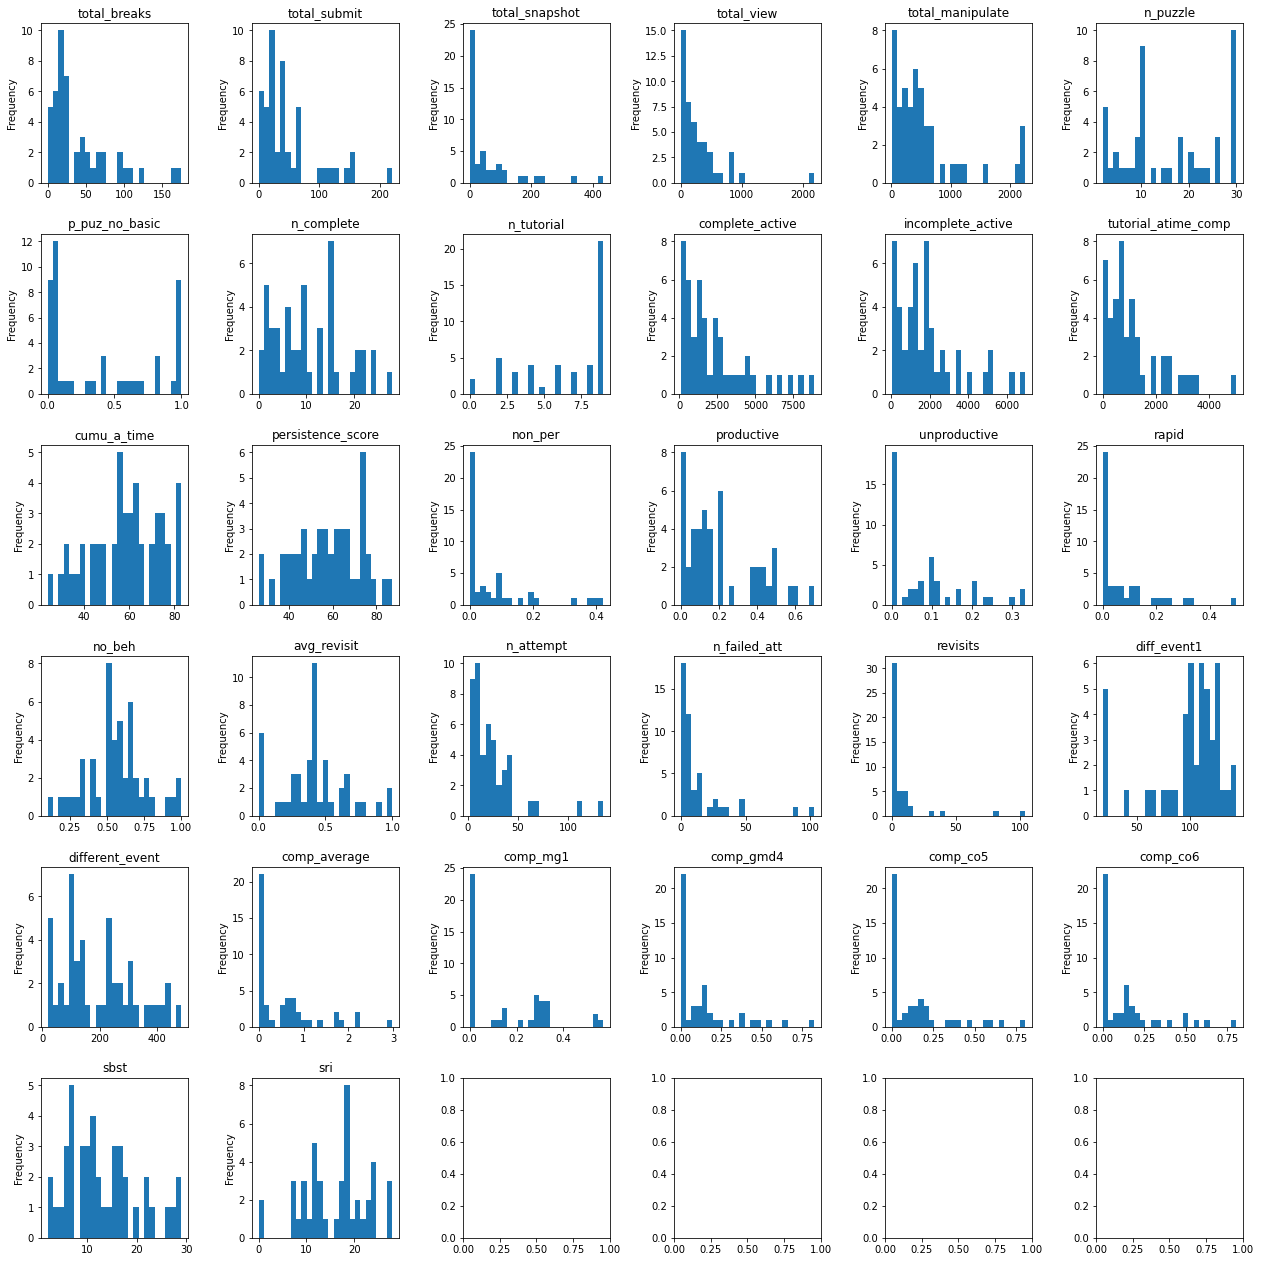

In [9]:
N = ceil(sqrt(len(features + labels)))
fig, axs = subplots(N, N)
fig.set_size_inches(3*N, 3*N)
fig.tight_layout(pad=3.0)
for i, col in enumerate(features + labels):
    data[col].plot(kind="hist", ax=axs[i//N][i%N], title=col, bins=25)

fig.savefig("output/hists.png")

## Percentages in binary categories

In [21]:
# gender
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

percent_male = len(data[data["gender_number"] == 0]) / len(data) * 100
print(f"Percent of students that are male: {percent_male:.4}")

# handedness
percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

percent_right = len(data[data["hand_number"] == 0]) / len(data) * 100
print(f"Percent of students that are right-handed: {percent_right:.4}")

# handedness
percent_gamer = len(data[data["gamer_number"] == 1]) / len(data) * 100
print(f"Percent of students that are gamers: {percent_gamer:.4}")

percent_nongamer = len(data[data["gamer_number"] == 0]) / len(data) * 100
print(f"Percent of students that are non-gamers: {percent_nongamer:.4}")

Percent of students that are female: 51.06
Percent of students that are male: 42.55
Percent of students that are left-handed: 19.15
Percent of students that are right-handed: 74.47
Percent of students that are gamers: 36.17
Percent of students that are non-gamers: 25.53


# Analysis

## Correlation

In [11]:
pw = pairwise_corr(data[features + labels + corr_extras])
pw.to_csv("output/corr.csv", sep="\t")
display(pw)

X                 Y   method alternative   n       r  \
0    total_breaks      total_submit  pearson   two-sided  47 0.81080   
1    total_breaks    total_snapshot  pearson   two-sided  47 0.43005   
2    total_breaks        total_view  pearson   two-sided  47 0.32167   
3    total_breaks  total_manipulate  pearson   two-sided  47 0.75261   
4    total_breaks          n_puzzle  pearson   two-sided  47 0.63588   
..            ...               ...      ...         ...  ..     ...   
590           sri                mr  pearson   two-sided  44 0.89109   
591           sri                sv  pearson   two-sided  44 0.86592   
592            so                mr  pearson   two-sided  44 0.61059   
593            so                sv  pearson   two-sided  44 0.61764   
594            mr                sv  pearson   two-sided  44 0.69591   

            CI95%   p-unc       BF10   power  
0    [0.68, 0.89] 0.00000  1.947e+09 1.00000  
1    [0.16, 0.64] 0.00255     15.021 0.86848  
2    [0.04, 0.56] 0.02746      1.922 0.60744  
3    [0.59, 0.85] 0.00000   1.22e+07 1.00000  
4    [0.43, 0.78] 0.00000    1.3e+04 0.99892  
..            ...     ...        ...     ...  
590  [0.81, 0.94] 0.00000  1.082e+13 1.00000  
591  [0.77, 0.93] 0.00000  2.203e+11 1.00000  
592  [0.38, 0.77] 0.00001    2199.77 0.99570  
593  [0.39, 0.77] 0.00001    2907.53 0.99654  
594   [0.5, 0.82] 0.00000  1.115e+05 0.99984  

[595 rows x 10 columns]

## Cronbach's Alpha

In [12]:
alpha, _ = cronbach_alpha(data=data[["so", "mr", "sv"]])
print(f"Cronbach's Alpha for SRI facets: {alpha}")

alpha, _ = cronbach_alpha(data=data[[f"sbst{i}" for i in range(1,31)]])
print(f"Cronbach's Alpha for SBST facets: {alpha}")

Cronbach's Alpha for SRI facets: 0.8359066056875625
Cronbach's Alpha for SBST facets: 0.8990425510278549


## ANOVA

In [13]:
# SRI and gender
aov = anova(data=data, dv="sri", between="gender")
print("ANOVA of sri between gender:")
display(aov)
print()

# SBST and gender
aov = anova(data=data, dv="sbst", between="gender")
print("ANOVA of sbst between gender:")
display(aov)
print()

# n_complete and gender
aov = anova(data=data, dv="n_complete", between="gender")
print("ANOVA of n_complete between gender:")
display(aov)
print()


# SRI and hand
aov = anova(data=data, dv="sri", between="hand_number")
print("ANOVA of sri between handedness:")
display(aov)
print()

# SBST and hand
aov = anova(data=data, dv="sbst", between="hand_number")
print("ANOVA of sbst between handedness:")
display(aov)
print()

# n_complete and hand
aov = anova(data=data, dv="n_complete", between="hand_number")
print("ANOVA of n_complete between handedness:")
display(aov)
print()


# SRI and gamer
aov = anova(data=data, dv="sri", between="gamer_number")
print("ANOVA of sri between gamerness:")
display(aov)
print()

# SBST and gamer
aov = anova(data=data, dv="sbst", between="gamer_number")
print("ANOVA of sbst between gamerness:")
display(aov)
print()

# n_complete and gamer
aov = anova(data=data, dv="n_complete", between="gamer_number")
print("ANOVA of n_complete between gamerness:")
display(aov)
print()

ANOVA of sri between gender:


Source  ddof1  ddof2       F   p-unc     np2
0  gender      1     42 1.77761 0.18963 0.04061


ANOVA of sbst between gender:


Source  ddof1  ddof2       F   p-unc     np2
0  gender      1     39 1.83402 0.18345 0.04491


ANOVA of n_complete between gender:


Source  ddof1  ddof2       F   p-unc     np2
0  gender      1     42 0.61479 0.43739 0.01443


ANOVA of sri between handedness:


Source  ddof1  ddof2       F   p-unc     np2
0  hand_number      1     42 0.53698 0.46776 0.01262


ANOVA of sbst between handedness:


Source  ddof1  ddof2       F   p-unc     np2
0  hand_number      1     39 0.18447 0.66992 0.00471


ANOVA of n_complete between handedness:


Source  ddof1  ddof2       F   p-unc     np2
0  hand_number      1     42 1.30183 0.26034 0.03006


ANOVA of sri between gamerness:


Source  ddof1  ddof2       F   p-unc     np2
0  gamer_number      1     26 0.15639 0.69573 0.00598


ANOVA of sbst between gamerness:


Source  ddof1  ddof2       F   p-unc     np2
0  gamer_number      1     27 0.30389 0.58599 0.01113


ANOVA of n_complete between gamerness:


Source  ddof1  ddof2       F   p-unc     np2
0  gamer_number      1     27 1.67202 0.20694 0.05832

## Linear Regression

In [14]:
linear_regression(data[features], data["sri"], remove_na=True, as_dataframe=True)

names            coef        se              T    pval  \
0             Intercept -30402467.06581  13.27373 -2290424.33758 0.00000   
1          total_breaks        -0.05006   0.12005       -0.41696 0.68303   
2          total_submit        -0.01895   0.09547       -0.19847 0.84553   
3        total_snapshot         0.00020   0.03900        0.00516 0.99596   
4            total_view        -0.01478   0.01168       -1.26533 0.22641   
5      total_manipulate        -0.00144   0.01093       -0.13176 0.89705   
6              n_puzzle        -0.62814   2.79800       -0.22450 0.82561   
7        p_puz_no_basic       -48.46825  54.07615       -0.89630 0.38525   
8            n_complete        -2.53388   2.95211       -0.85833 0.40517   
9            n_tutorial         5.92721   4.13831        1.43228 0.17401   
10      complete_active        -0.00156   0.00241       -0.64927 0.52667   
11    incomplete_active        -0.00115   0.00261       -0.44205 0.66520   
12  tutorial_atime_comp        -0.00022   0.00474       -0.04656 0.96352   
13          cumu_a_time        -0.06768   0.49846       -0.13577 0.89393   
14    persistence_score        -0.34128   0.58086       -0.58755 0.56619   
15              non_per  30402512.01092  24.00608  1266450.69953 0.00000   
16           productive  30402529.96344  15.60187  1948646.26595 0.00000   
17         unproductive  30402521.87033  21.10511  1440528.91682 0.00000   
18                rapid  30402501.49754  12.84640  2366616.08571 0.00000   
19               no_beh  30402500.52371   7.81671  3889422.90833 0.00000   
20          avg_revisit         7.74266   8.67454        0.89257 0.38717   
21            n_attempt        -0.88531   1.19052       -0.74363 0.46940   
22         n_failed_att         1.53508   1.59644        0.96156 0.35258   
23             revisits        -0.50437   0.70327       -0.71718 0.48506   
24          diff_event1        -0.42098   0.24550       -1.71478 0.10843   
25      different_event         0.31482   0.15632        2.01388 0.06365   
26         comp_average        14.40350  14.62301        0.98499 0.34135   
27             comp_mg1       -28.73121  21.26166       -1.35132 0.19803   
28            comp_gmd4        92.75325 105.92212        0.87567 0.39598   
29             comp_co5      -190.12993 145.42206       -1.30744 0.21213   
30             comp_co6       140.51138 148.37389        0.94701 0.35969   

        r2  adj_r2        CI[2.5%]       CI[97.5%]  
0  0.74148 0.20598 -30402495.53512 -30402438.59650  
1  0.74148 0.20598        -0.30754         0.20742  
2  0.74148 0.20598        -0.22372         0.18582  
3  0.74148 0.20598        -0.08343         0.08384  
4  0.74148 0.20598        -0.03983         0.01027  
5  0.74148 0.20598        -0.02489         0.02201  
6  0.74148 0.20598        -6.62926         5.37298  
7  0.74148 0.20598      -164.45005        67.51355  
8  0.74148 0.20598        -8.86552         3.79776  
9  0.74148 0.20598        -2.94858        14.80300  
10 0.74148 0.20598        -0.00673         0.00360  
11 0.74148 0.20598        -0.00674         0.00444  
12 0.74148 0.20598        -0.01038         0.00994  
13 0.74148 0.20598        -1.13677         1.00141  
14 0.74148 0.20598        -1.58710         0.90453  
15 0.74148 0.20598  30402460.52301  30402563.49883  
16 0.74148 0.20598  30402496.50075  30402563.42613  
17 0.74148 0.20598  30402476.60437  30402567.13629  
18 0.74148 0.20598  30402473.94475  30402529.05033  
19 0.74148 0.20598  30402483.75853  30402517.28889  
20 0.74148 0.20598       -10.86239        26.34770  
21 0.74148 0.20598        -3.43873         1.66811  
22 0.74148 0.20598        -1.88895         4.95911  
23 0.74148 0.20598        -2.01274         1.00399  
24 0.74148 0.20598        -0.94753         0.10557  
25 0.74148 0.20598        -0.02046         0.65010  
26 0.74148 0.20598       -16.95973        45.76673  
27 0.74148 0.20598       -74.33294        16.87053  
28 0.74148 0.20598      -134.42711       319.933

In [15]:
lr_features = ["n_puzzle", "p_puz_no_basic", "complete_active", "incomplete_active", "non_per", "productive", "unproductive", "rapid", "no_beh"]
linear_regression(data[lr_features], data["sri"], remove_na=True, as_dataframe=True, relimp=True)

names           coef       se              T    pval      r2  \
0          Intercept -5946358.36605  4.12852 -1440312.80462 0.00000 0.28120   
1           n_puzzle       -0.73853  0.65175       -1.13316 0.26508 0.28120   
2     p_puz_no_basic       22.90016 18.41390        1.24363 0.22214 0.28120   
3    complete_active        0.00032  0.00090        0.36037 0.72080 0.28120   
4  incomplete_active       -0.00109  0.00087       -1.24920 0.22012 0.28120   
5            non_per  5946371.90988  9.45205   629109.26978 0.00000 0.28120   
6         productive  5946384.74064  8.79381   676201.31107 0.00000 0.28120   
7       unproductive  5946366.83446 10.12060   587550.60570 0.00000 0.28120   
8              rapid  5946396.57714  8.24939   720828.65914 0.00000 0.28120   
9             no_beh  5946376.35230  4.57615  1299427.88455 0.00000 0.28120   

   adj_r2       CI[2.5%]      CI[97.5%]  relimp  relimp_perc  
0 0.09093 -5946366.75621 -5946349.97589     NaN          NaN  
1 0.09093       -2.06304        0.58598 0.02386      8.51754  
2 0.09093      -14.52140       60.32171 0.03447     12.30267  
3 0.09093       -0.00151        0.00216 0.02758      9.84400  
4 0.09093       -0.00287        0.00069 0.02735      9.76244  
5 0.09093  5946352.70100  5946391.11875 0.00722      2.57605  
6 0.09093  5946366.86948  5946402.61181 0.01178      4.20557  
7 0.09093  5946346.26692  5946387.40200 0.05518     19.69409  
8 0.09093  5946379.81236  5946413.34191 0.08251     29.44870  
9 0.09093  5946367.05245  5946385.65216 0.01022      3.64894

## Random Forest and XGB

### Helper

In [16]:
# specify the models
label_dict = {
    label: data[data[label] > 0].dropna(subset=everything)
    for label in labels
}

model_dict = {
    "xgb": XGBRegressor(tree_method="hist", random_state=42),
    "rf": RandomForestRegressor(n_estimators=1000, random_state=42)
}

param_dict = { # TODO
    "xgb": {},
    "rf": {
        # 'bootstrap': [True, False], # omitting
        # 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], # narrowed with grid search
        "max_depth": [5, 10, 20],
        # 'max_features': ['auto', 'sqrt'], # narrowed with grid search
        "max_features": ["sqrt"],
        # 'min_samples_leaf': [1, 2, 4], # omitting
        # 'min_samples_split': [2, 5, 10], # omitting
        # 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000] # narrowed with random search
        # 'n_estimators': [200, 400, 600, 800] # narrowed with grid search
        # 'n_estimators': [100, 200, 400, 600] # narrowed with grid search
        # "n_estimators": [150, 200, 250, 300, 350, 400, 450, 500] # narrowed with grid search
        "n_estimators": [150, 400]
    }
}

# Helper to compare r^2 values using fisher z transforms
def fzt(r2_score_1, n_1, r2_score_2, n_2):
    try:
        r1 = sqrt(r2_score_1)
        r2 = sqrt(r2_score_2)
        z1 = log((1+r1) / (1-r1)) / 2
        z2 = log((1+r2) / (1-r2)) / 2
        z_score = (z1 - z2) / sqrt((1 / (n_1-3)) + (1 / (n_2-3)))
        return z_score
    except ValueError:
        return None

# Helper to run all the steps for a given dependent variable and regressor
def run_regressor(m, label, features, protecteds):
    
    # Heading
    display(Markdown(f"---\n\n# {m} {label}"))
    
    # Conventional Shorthand
    model = model_dict[m]
    subdata = label_dict[label]
    X = subdata[features]
    y = subdata[label]
    
    # Hyperparameter tuning
    parameters = param_dict[m]
    # search = RandomizedSearchCV(model, parameters, scoring="r2", n_iter=200, cv=2, verbose=2, random_state=42, n_jobs=-1)
    search = GridSearchCV(model, parameters, scoring="r2", cv=5, verbose=2, n_jobs=-1)
    search.fit(X, y)
    display(Markdown(f"**Hyperparameters:**"))
    display(DataFrame(search.best_params_, index=[0]))
    model.set_params(**search.best_params_)
    
    # Fit model
    yhat = cross_val_predict(model, X, y, cv=5)
    model.fit(X, y)
    
    # Check goodness
    errors = abs(yhat - y)
    mae = round(mean(errors), 2)
    display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
    display(Markdown(f"**Summary Stats:**"))
    display(DataFrame({
        "mean": [mean(y)],
        "std": [std(y)]
    }))
    display(Markdown(f"**Pearson:**"))
    display(corr(yhat, y))
    display(Markdown(f"**R^2 Score:**"))
    display(r2_score(y, yhat))
    
    # Explain features
    explain = Explainer(model, X, y, verbose=False)
    explain.model_parts().plot()
    
    # Check fairness
    for col in protecteds:
        display(Markdown(f"## {col}"))
        prev_n = None
        prev_r2 = None
        for c in unique(subdata[col].values):
            if not isnan(c) and c is not None: 
                display(Markdown(f"### where {col}=={c}"))
                rows = subdata[col] == c
                mae = round(mean(errors[rows]), 2)
                pc = corr(yhat[rows], y[rows])
                r2 = r2_score(y[rows], yhat[rows])
                display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
                display(Markdown(f"**Summary Stats:**"))
                display(DataFrame({
                    "mean": [mean(y[rows])],
                    "std": [std(y[rows])]
                }))
                display(Markdown(f"**Pearson:**"))
                display(pc)
                display(Markdown(f"**Fairness:**"))
                fair = explain.model_fairness(array([str(c) if row else "else" for row in rows]), "else")
                display(fair.plot())
                display(Markdown(f"**R^2 Score:**"))
                display(r2)
                if prev_n is not None:
                    z = fzt(prev_r2, prev_n, r2, pc["n"])
                    display(Markdown(f"**Z Score:**"))
                    display(z)

                prev_n = pc["n"]
                prev_r2 = r2

### Run

---

# rf sri

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ..max_depth=10, max_features=sqrt, n_est

**Hyperparameters:**

max_depth max_features  n_estimators
0          5         sqrt           400

**Mean Absolute Error:** 4.27 degrees.

**Summary Stats:**

mean     std
0 16.72500 5.98326

**Pearson:**

n       r         CI95%   p-val    BF10   power
pearson  40 0.57156  [0.32, 0.75] 0.00012  252.36 0.97903

**R^2 Score:**

0.32545083176671585

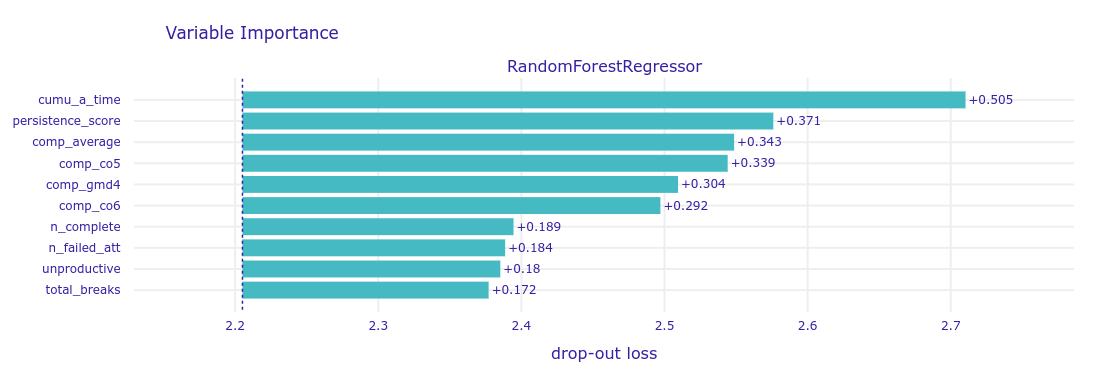

## gender_number

### where gender_number==0.0

**Mean Absolute Error:** 5.22 degrees.

**Summary Stats:**

mean     std
0 19.52941 5.88235

**Pearson:**

n       r          CI95%   p-val   BF10   power
pearson  17 0.38772  [-0.11, 0.73] 0.12411  0.896 0.34803

**Fairness:**

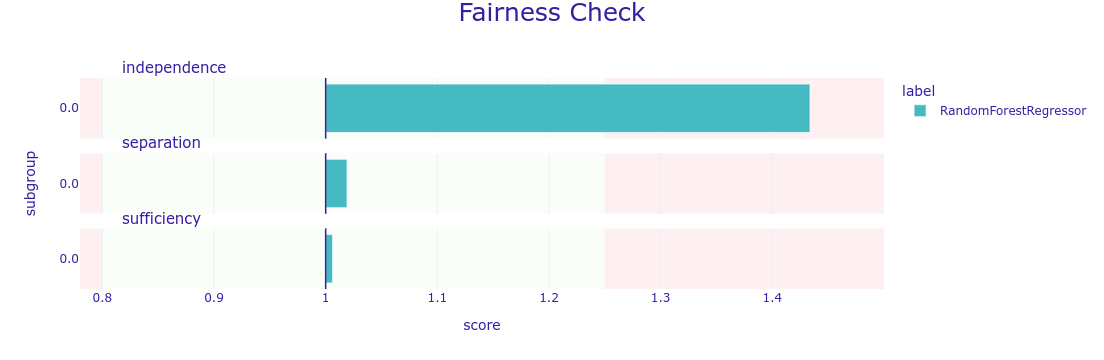

None

**R^2 Score:**

0.0671430880966255

### where gender_number==1.0

**Mean Absolute Error:** 3.57 degrees.

**Summary Stats:**

mean     std
0 14.65217 5.15506

**Pearson:**

n       r         CI95%   p-val    BF10   power
pearson  23 0.59563  [0.24, 0.81] 0.00271  17.762 0.87786

**Fairness:**

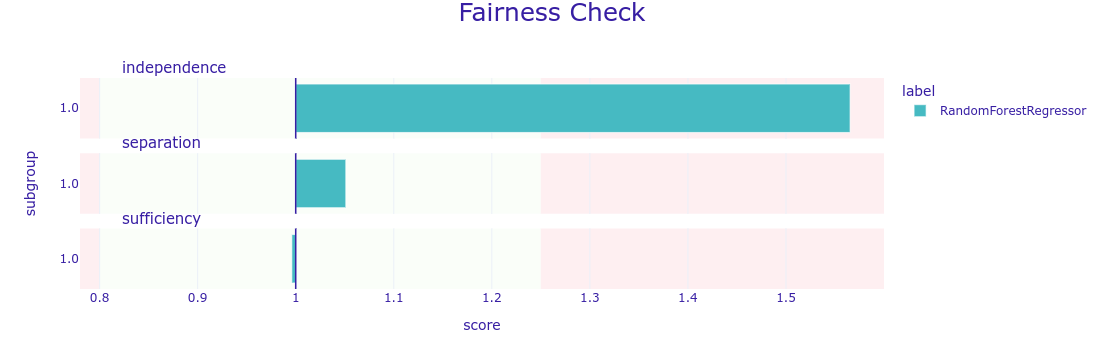

None

**R^2 Score:**

0.3174307682126193

**Z Score:**

-1.069402098539458

## hand_number

### where hand_number==0.0

**Mean Absolute Error:** 4.12 degrees.

**Summary Stats:**

mean     std
0 16.48387 5.59303

**Pearson:**

n       r         CI95%   p-val    BF10   power
pearson  31 0.50786  [0.19, 0.73] 0.00354  12.987 0.85151

**Fairness:**

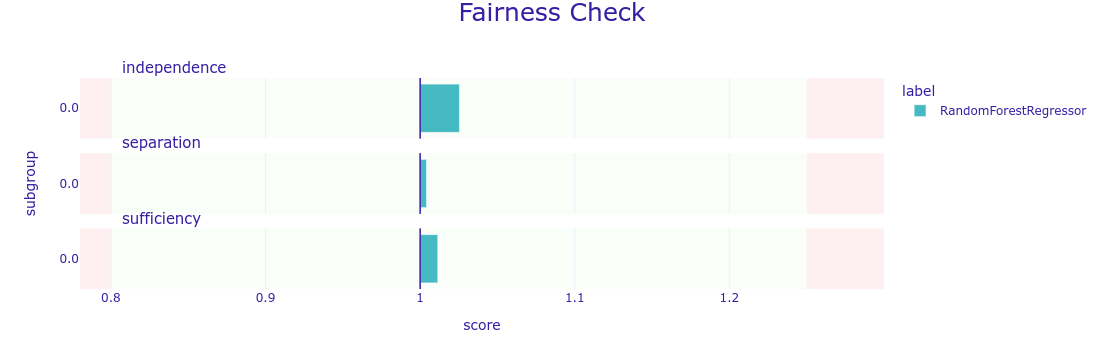

None

**R^2 Score:**

0.25379531906495123

### where hand_number==1.0

**Mean Absolute Error:** 4.79 degrees.

**Summary Stats:**

mean     std
0 17.55556 7.10416

**Pearson:**

n       r         CI95%   p-val   BF10   power
pearson  9 0.73569  [0.14, 0.94] 0.02386  3.719 0.67284

**Fairness:**

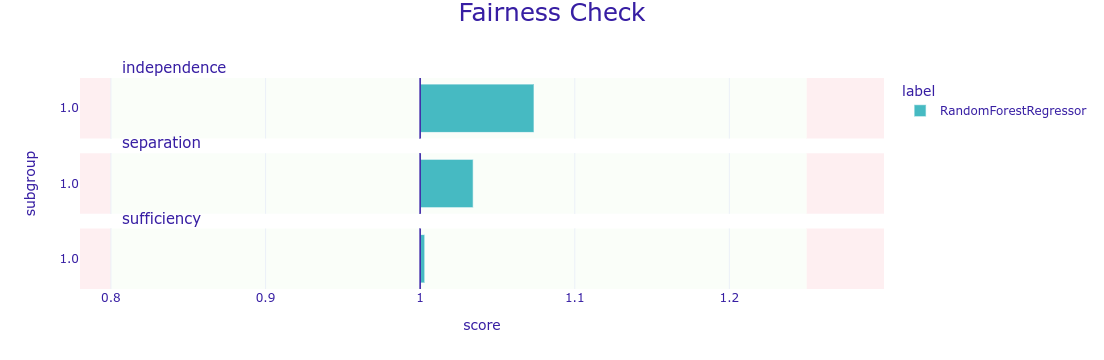

None

**R^2 Score:**

0.46653518527054616

**Z Score:**

-0.6233361289092513

## gamer_number

### where gamer_number==0.0

**Mean Absolute Error:** 3.21 degrees.

**Summary Stats:**

mean     std
0 17.18182 5.93630

**Pearson:**

n       r         CI95%   p-val    BF10   power
pearson  11 0.77413  [0.33, 0.94] 0.00517  11.621 0.85420

**Fairness:**

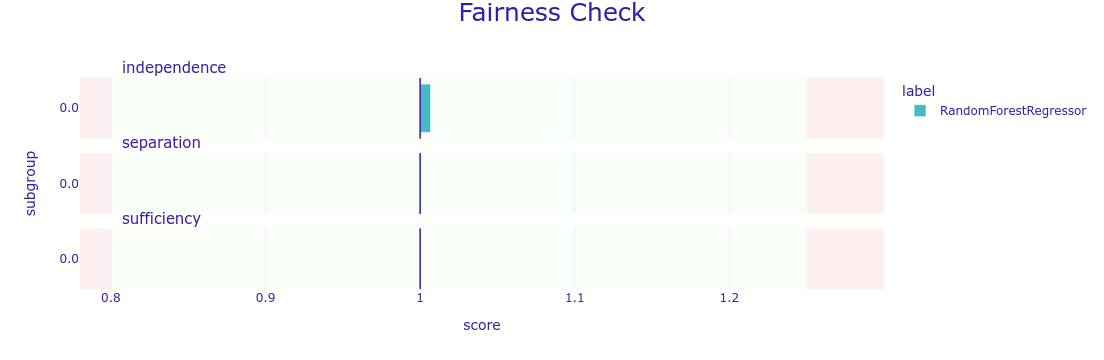

None

**R^2 Score:**

0.5703330710122569

### where gamer_number==1.0

**Mean Absolute Error:** 4.85 degrees.

**Summary Stats:**

mean     std
0 17.12500 6.09175

**Pearson:**

n       r          CI95%   p-val   BF10   power
pearson  16 0.47394  [-0.03, 0.79] 0.06365  1.505 0.47880

**Fairness:**

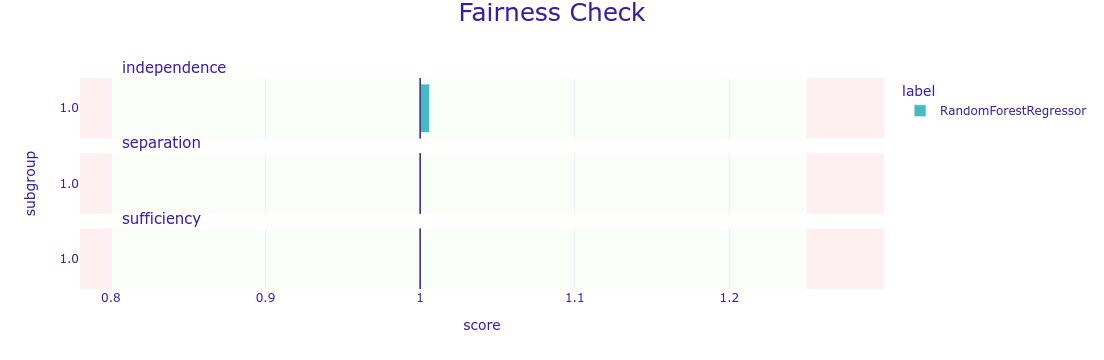

None

**R^2 Score:**

0.22013980845980097

**Z Score:**

1.059122297162316

In [17]:
run_regressor("rf", "sri", features, protecteds)

---

# rf sbst

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END ..max_depth=10, max_features=sqrt, n_est

**Hyperparameters:**

max_depth max_features  n_estimators
0          5         sqrt           150

**Mean Absolute Error:** 5.04 degrees.

**Summary Stats:**

mean     std
0 12.97561 7.05894

**Pearson:**

n       r        CI95%   p-val    BF10   power
pearson  41 0.49525  [0.22, 0.7] 0.00099  36.416 0.92251

**R^2 Score:**

0.2416659386890846

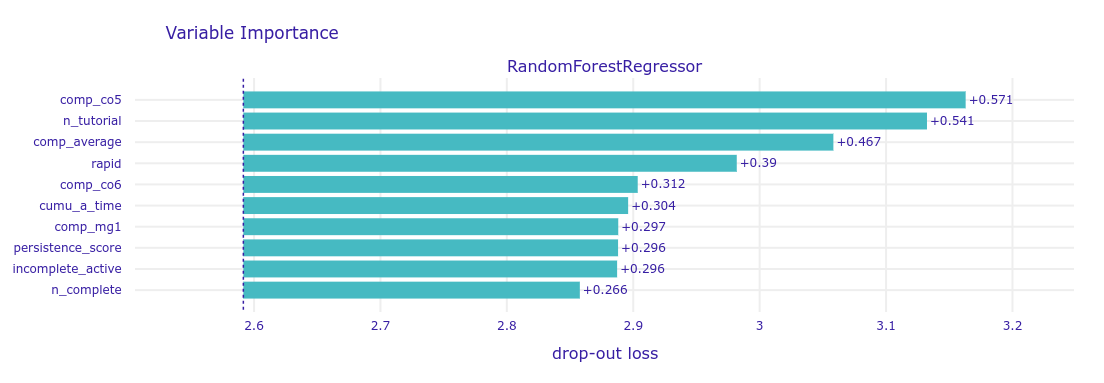

## gender_number

### where gender_number==0.0

**Mean Absolute Error:** 5.51 degrees.

**Summary Stats:**

mean     std
0 14.66667 8.07603

**Pearson:**

n       r        CI95%   p-val   BF10   power
pearson  18 0.53477  [0.09, 0.8] 0.02222  3.295 0.65741

**Fairness:**

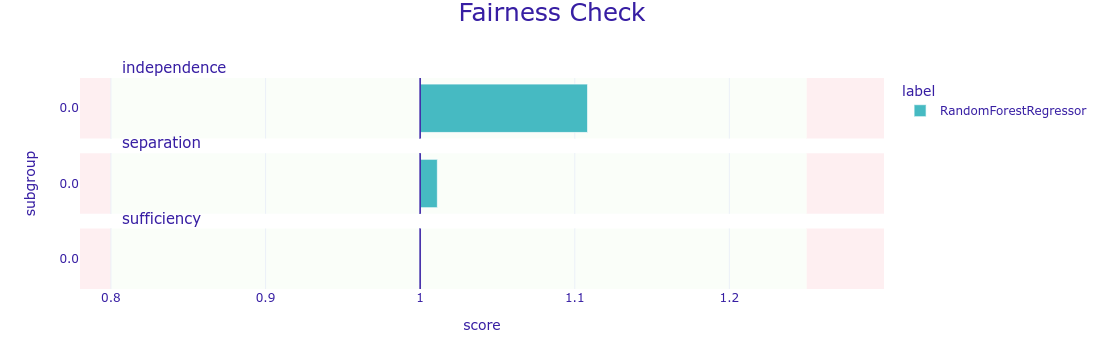

None

**R^2 Score:**

0.2827506192412397

### where gender_number==1.0

**Mean Absolute Error:** 4.68 degrees.

**Summary Stats:**

mean     std
0 11.65217 5.81309

**Pearson:**

n       r          CI95%   p-val  BF10   power
pearson  23 0.36849  [-0.05, 0.68] 0.08361  1.06 0.42127

**Fairness:**

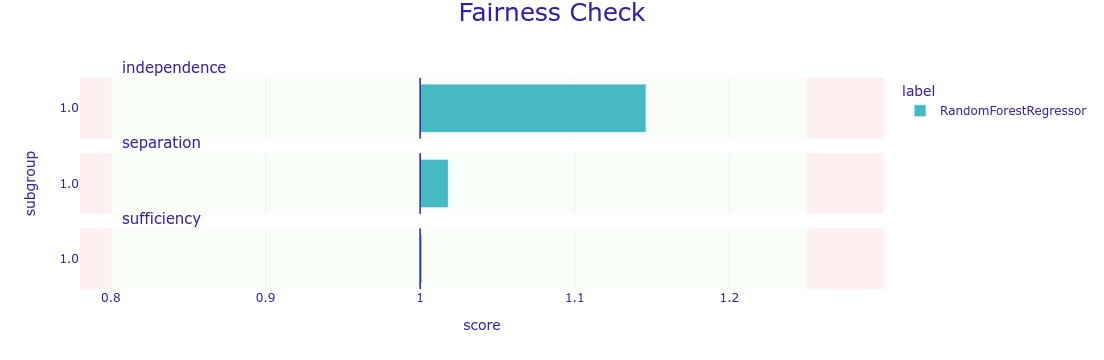

None

**R^2 Score:**

0.09007798048902937

**Z Score:**

0.8282749262749115

## hand_number

### where hand_number==0.0

**Mean Absolute Error:** 4.87 degrees.

**Summary Stats:**

mean     std
0 12.71875 7.09416

**Pearson:**

n       r         CI95%   p-val   BF10   power
pearson  32 0.52904  [0.22, 0.74] 0.00185  22.65 0.89484

**Fairness:**

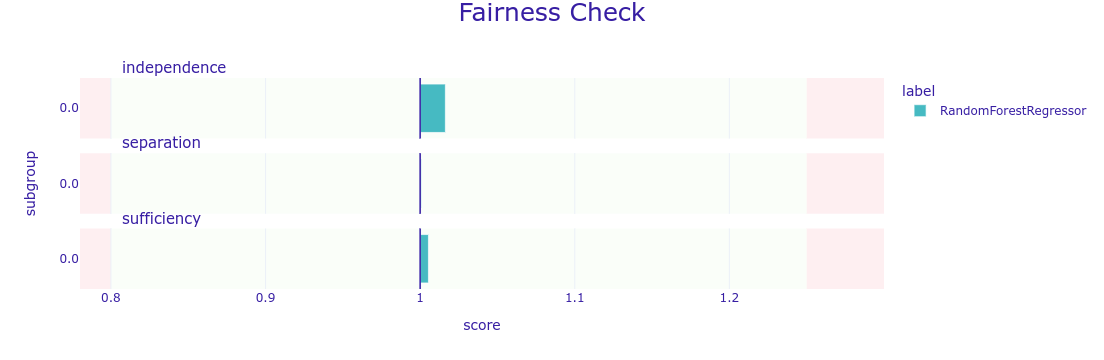

None

**R^2 Score:**

0.27797409756097613

### where hand_number==1.0

**Mean Absolute Error:** 5.65 degrees.

**Summary Stats:**

mean     std
0 13.88889 6.85475

**Pearson:**

n       r          CI95%   p-val   BF10   power
pearson  9 0.42124  [-0.34, 0.85] 0.25884  0.715 0.21124

**Fairness:**

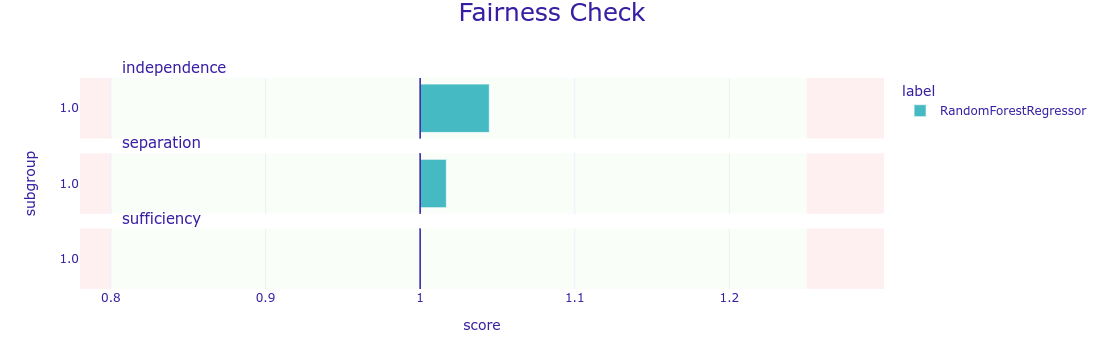

None

**R^2 Score:**

0.0861480429238054

**Z Score:**

0.633007121682948

## gamer_number

### where gamer_number==0.0

**Mean Absolute Error:** 5.05 degrees.

**Summary Stats:**

mean     std
0 13.81818 7.88345

**Pearson:**

n       r         CI95%   p-val   BF10   power
pearson  11 0.68067  [0.14, 0.91] 0.02114  3.916 0.68268

**Fairness:**

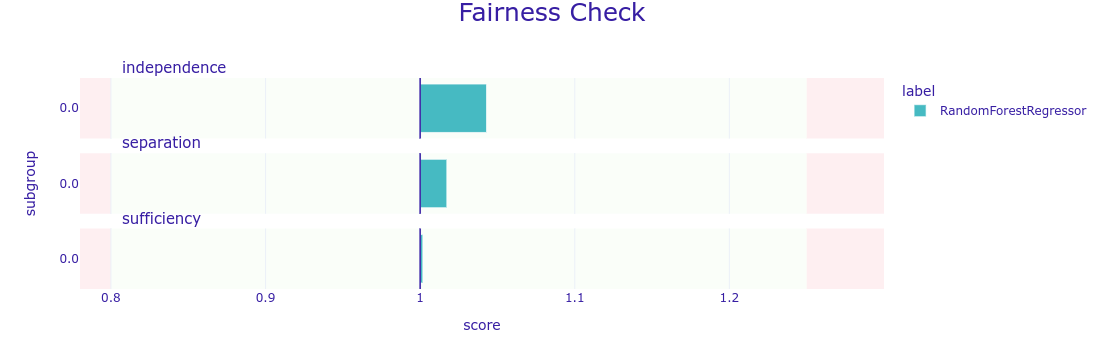

None

**R^2 Score:**

0.4509505688944978

### where gamer_number==1.0

**Mean Absolute Error:** 4.59 degrees.

**Summary Stats:**

mean     std
0 12.52941 6.92920

**Pearson:**

n       r        CI95%   p-val   BF10   power
pearson  17 0.51675  [0.05, 0.8] 0.03367  2.412 0.59213

**Fairness:**

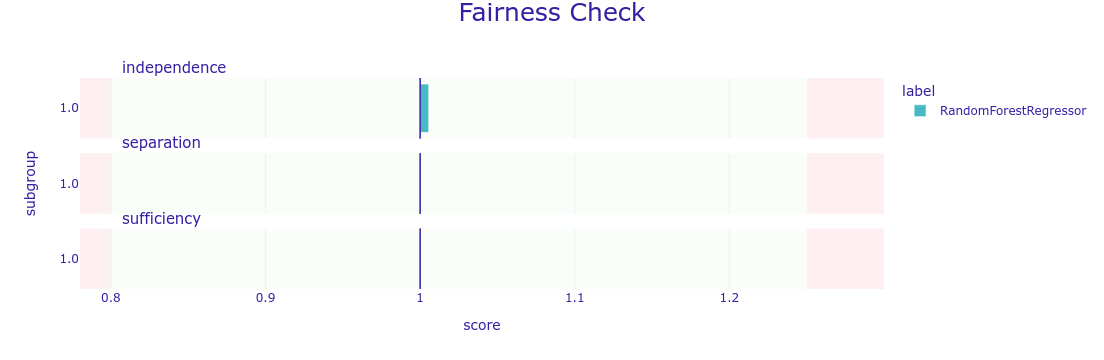

None

**R^2 Score:**

0.25264483662526904

**Z Score:**

0.588201319220648

In [18]:
run_regressor("rf", "sbst", features, protecteds)

In [19]:
# run_regressor("xgb", "sri", features, protecteds)

In [20]:
# run_regressor("xgb", "sbst", features, protecteds)